# Introduction and Imports

![Credit: Pexels](https://images.pexels.com/photos/3862130/pexels-photo-3862130.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

In this notebook, I will be using only **Machine Learning** methods to get decent prediction scores. There are much better and sophisticated ways (like RNN, GRU, Fine-tuning BERT, etc) but you have seen them on a lot of notebook already.

The main aim of this notebook is to just show how quickly and easily you can do Text Classification using Basic Machine Learning Methods, rather than spend waiting 1 hour for a model to train!

<p style="color:red">If you like this notebook, please make sure to give an upvote, it helps a lot and motivates me to make much more good-quality content</p>
<p style="color:blue">If you don't like my work, please leave a comment on what can I do to make it better!</p>
<hr>
<h3 style="color:aqua">Edits:</h3>
<ul>
<li style="color:green">All Classifiers now classify for all 3 categories and not just 2. Good Validation Accuracy is maintained.</li>
</ul>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import random
warnings.simplefilter("ignore")

In [4]:
def plot_metric(clf, testX, testY, name):
    """
    Small function to plot ROC-AUC values and confusion matrix
    """
    styles = ['bmh', 'classic', 'fivethirtyeight', 'ggplot']

    plt.style.use(random.choice(styles))
    plot_confusion_matrix(clf, testX, testY)
    plt.title(f"Confusion Matrix [{name}]")

# Data Preprocessing and Some EDA

Read the data and don't use the low quality edit data

In [5]:
data = pd.read_csv("C:\\Users\\Sanjay\\Downloads\\project 4 seg\\train.csv\\train.csv")
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [6]:
data.shape

(45000, 6)

All the open questions are grouped under a single class (1), while the closed one is grouped under (0)

In [7]:
data = data.drop(['Id', 'Tags', 'CreationDate'], axis=1)
data['Y'] = data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
data.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,2


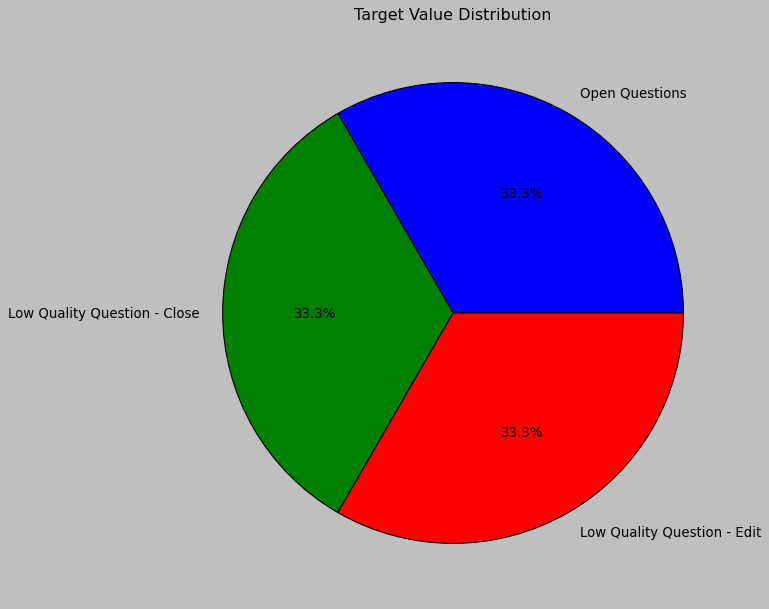

In [8]:
labels = ['Open Questions', 'Low Quality Question - Close', 'Low Quality Question - Edit']
values = [len(data[data['Y'] == 2]), len(data[data['Y'] == 0]), len(data[data['Y'] == 1])]
plt.style.use('classic')
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

Let's join the title and the body of the text data so that we can use both of them in our classification

In [9]:
data['text'] = data['Title'] + ' ' + data['Body']
data = data.drop(['Title', 'Body'], axis=1)
data.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,2,Why are Java Optionals immutable? <p>I'd like ...
2,2,Text Overlay Image with Darkened Opacity React...
3,2,Why ternary operator in swift is so picky? <p>...
4,2,hide/show fab with scale animation <p>I'm usin...


In [10]:
# Clean the data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text
data['text'] = data['text'].apply(clean_text)

## Splitting the Data
Let's now split the dataset into training and validation sets

In [11]:
# Define how much percent data you wanna split
split_pcent = 0.20
split = int(split_pcent * len(data))

# Shuffles dataframe
data = data.sample(frac=1).reset_index(drop=True)

# Training Sets
train = data[split:]
trainX = train['text']
trainY = train['Y'].values

# Validation Sets
valid = data[:split]
validX = valid['text']
validY = valid['Y'].values

assert trainX.shape == trainY.shape
assert validX.shape == validY.shape

print(f"Training Data Shape: {validX.shape}\nValidation Data Shape: {validX.shape}")

Training Data Shape: (9000,)
Validation Data Shape: (9000,)


## Vectorizing the Data
Let's vectorize the data so it's in the numerical format

In [12]:
# Load the vectorizer, fit on training set, transform on validation set
vectorizer = TfidfVectorizer()
trainX = vectorizer.fit_transform(trainX)
validX = vectorizer.transform(validX)

# Modelling
Let's start with different non-deep learning approaches for this task.

## 1. Logistic Regression
Let's first start with our good old, Logistic Regression!

In [13]:
# Define and fit the classifier on the data
lr_classifier = LogisticRegression(C=1.)
lr_classifier.fit(trainX, trainY)

LogisticRegression()

In [15]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Logsitic Regression Classifier is: {(lr_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Logsitic Regression Classifier is: 87.16%


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import label_binarize

def plot_metric(clf, testX, testY, name):
    """
    Function to plot ROC-AUC values and confusion matrix for multiclass classification
    """
    styles = ['bmh', 'classic', 'fivethirtyeight', 'ggplot']
    plt.style.use(random.choice(styles))

    # Predict probabilities for ROC-AUC
    y_proba = clf.predict_proba(testX)
    n_classes = y_proba.shape[1]
    
    # Binarize the output
    y_test_binarized = label_binarize(testY, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves [{name}]')
    plt.legend(loc='lower right')

    # Compute and plot confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_pred = clf.predict(testX)
    cm = confusion_matrix(testY, y_pred)
    
    plt.subplot(1, 2, 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f"Confusion Matrix [{name}]")

    plt.tight_layout()
    plt.show()

    # Debugging output
    print("ROC-AUC:", roc_auc)
    print("Confusion Matrix:\n", cm)


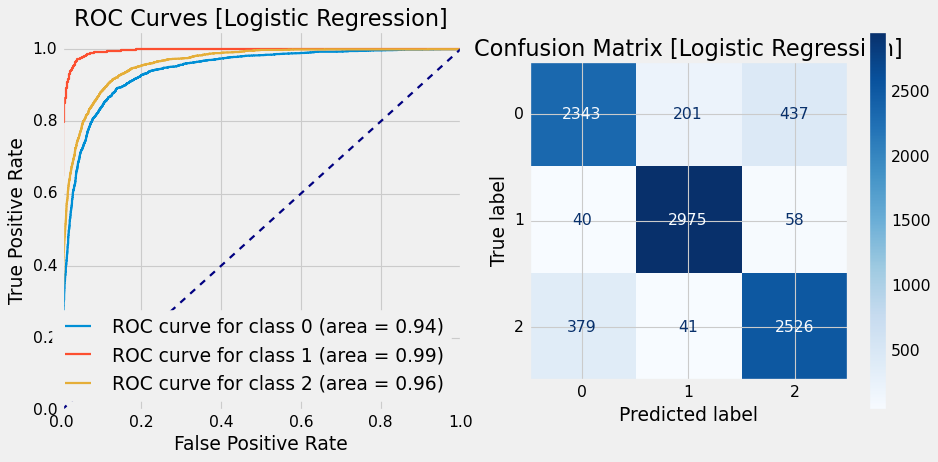

ROC-AUC: {0: 0.9412798195404812, 1: 0.9942151145697098, 2: 0.959959257831362}
Confusion Matrix:
 [[2343  201  437]
 [  40 2975   58]
 [ 379   41 2526]]


In [17]:
# Plot metrics
plot_metric(lr_classifier, validX, validY, "Logistic Regression")

## 2. Multinomial Naive Bayes
Let's now switch to the naive the bayes, the NAIVE BAYES!

In [14]:
# Define and fit the classifier on the data
nb_classifier = MultinomialNB()
nb_classifier.fit(trainX, trainY)

MultinomialNB()

In [18]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 77.43%


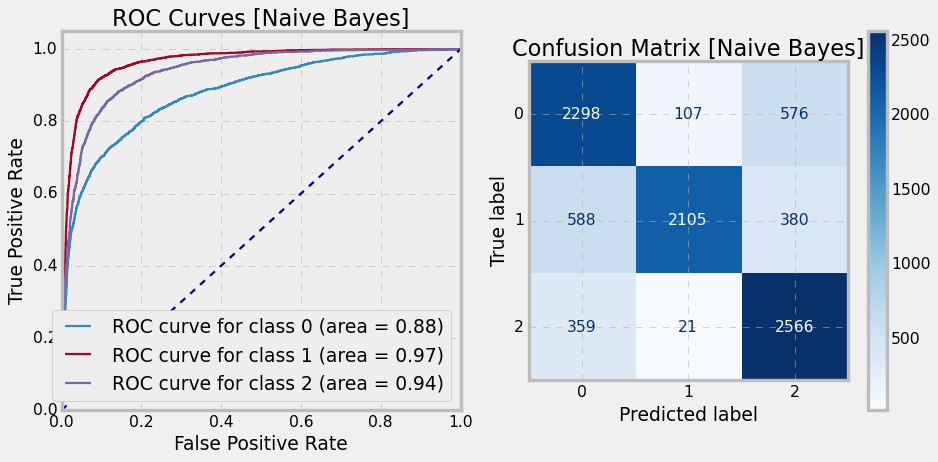

ROC-AUC: {0: 0.8809103276279482, 1: 0.9650602012082024, 2: 0.9397604182856667}
Confusion Matrix:
 [[2298  107  576]
 [ 588 2105  380]
 [ 359   21 2566]]


In [19]:
# Also plot the metric
plot_metric(nb_classifier, validX, validY, "Naive Bayes")

## 3. Random Forest Classifier
Let's now enter the forest with the Random Forest Classifier and see where it takes us!

In [20]:
# Define and fit the classifier on the data
rf_classifier = RandomForestClassifier()
rf_classifier.fit(trainX, trainY)

RandomForestClassifier()

In [22]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 83.10%


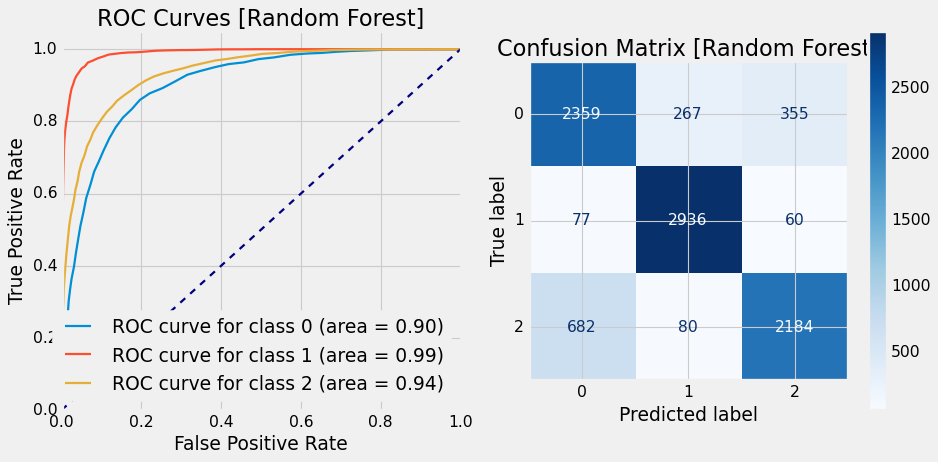

ROC-AUC: {0: 0.9037218549623609, 1: 0.9884255074114384, 2: 0.9350758033996364}
Confusion Matrix:
 [[2359  267  355]
 [  77 2936   60]
 [ 682   80 2184]]


In [23]:
# Also plot the metric
plot_metric(rf_classifier, validX, validY, "Random Forest")

## 4. Decision Tree Classifier
Let's now take some decisions using the Decision Tree Classifer

In [21]:
# Define and fit the classifier on the data
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(trainX, trainY)

DecisionTreeClassifier()

In [24]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Decision Tree Clf. is: 78.77%


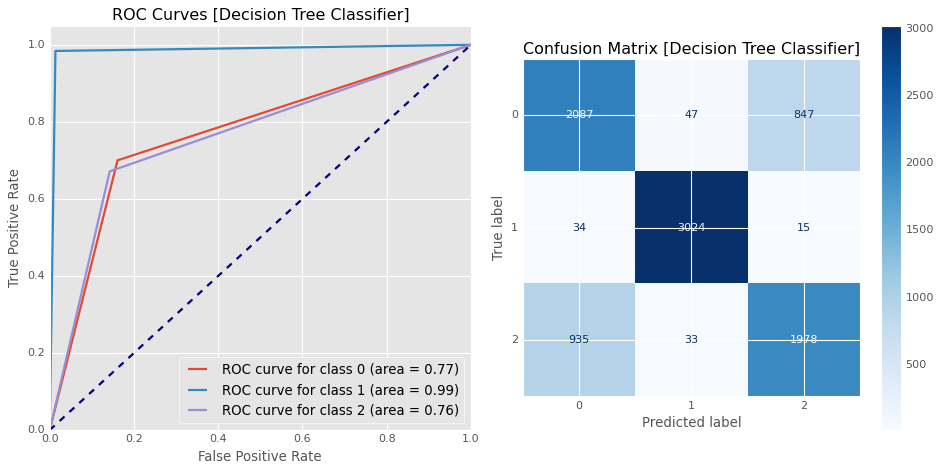

ROC-AUC: {0: 0.7695552198313749, 1: 0.9852785580677282, 2: 0.7645168365901724}
Confusion Matrix:
 [[2087   47  847]
 [  34 3024   15]
 [ 935   33 1978]]


In [25]:
# Also plot the metric
plot_metric(dt_classifier, validX, validY, "Decision Tree Classifier")

## 5. KNN Classifier
We now are going to use KNN Classifier for this task.

In [26]:
# Define and fit the classifier on the data
kn_classifier = KNeighborsClassifier()
kn_classifier.fit(trainX, trainY)

KNeighborsClassifier()

In [27]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of KNN Clf. is: {(kn_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of KNN Clf. is: 56.60%


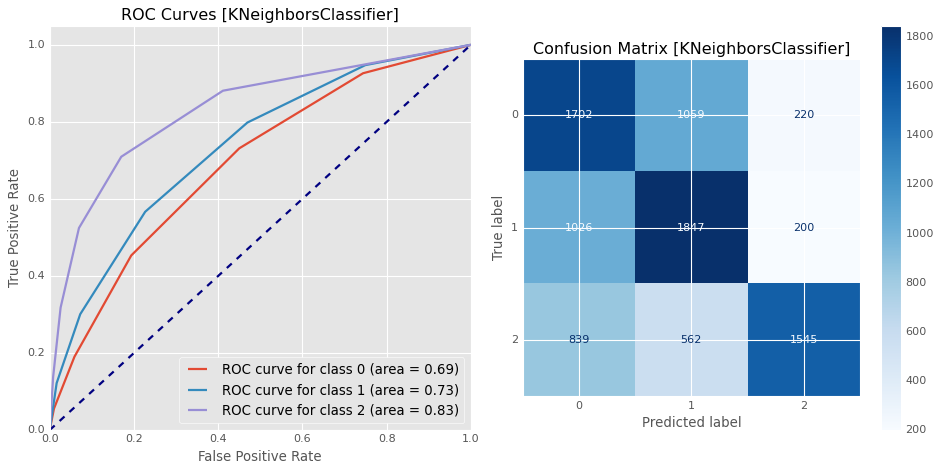

ROC-AUC: {0: 0.6917239710390428, 1: 0.7337699797037072, 2: 0.8305624464678719}
Confusion Matrix:
 [[1702 1059  220]
 [1026 1847  200]
 [ 839  562 1545]]


In [28]:
# Also plot the metric
plot_metric(kn_classifier, validX, validY, "KNeighborsClassifier")

## 6. XGBoost
Finally, let's use the XGBoost Classifier and then we'll compare all the different classifiers so far

In [29]:
# Define and fit the classifier on the data
xg_classifier = XGBClassifier()
xg_classifier.fit(trainX, trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [30]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of XGBoost Clf. is: {(xg_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of XGBoost Clf. is: 87.97%


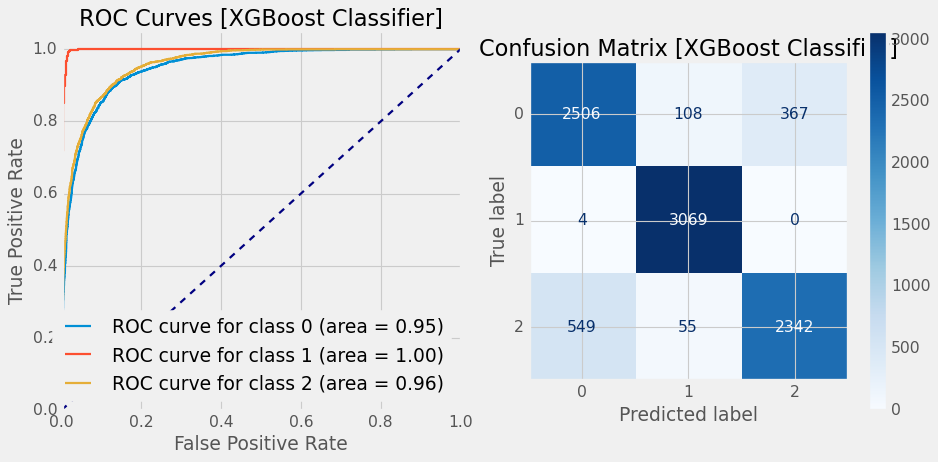

ROC-AUC: {0: 0.9501472442264484, 1: 0.9978030238934259, 2: 0.9581361657730348}
Confusion Matrix:
 [[2506  108  367]
 [   4 3069    0]
 [ 549   55 2342]]


In [31]:
# Also plot the metric
plot_metric(xg_classifier, validX, validY, "XGBoost Classifier")

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define and fit the initial classifier
xg_classifier = XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xg_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model using the training data
grid_search.fit(trainX, trainY)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Print the cross-validation accuracy for the best model
print(f"Best cross-validation accuracy: {(grid_search.best_score_)*100:.2f}%")

# Get the best model from GridSearchCV
best_xg_classifier = grid_search.best_estimator_

# Evaluate the best model on the validation set
validation_accuracy = best_xg_classifier.score(validX, validY)
print(f"Validation Accuracy of the tuned XGBoost Clf. is: {validation_accuracy*100:.2f}%")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
